In [1]:
import os
import csv
import cv2
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
def dnorm(x, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power(x / sd, 2) / 2)

In [3]:
def myGaussianKernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], sigma)
    print(kernel_1D)
    
    kernel_2D = np.outer(kernel_1D, kernel_1D)
    kernel_2D *= 1.0 / kernel_2D.max()
    
    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel Image")
        plt.show()

    return kernel_2D

[0.12098536 0.17603266 0.19947114 0.17603266 0.12098536]


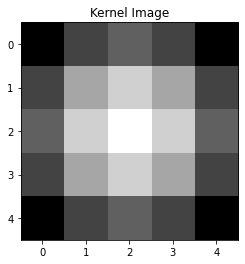

array([[0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.60653066, 0.8824969 , 1.        , 0.8824969 , 0.60653066],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944]])

In [4]:
# kernel = cv2.getGaussianKernel(5, sigma=2) # skip built in method
kernel = myGaussianKernel(size=5, sigma=2, verbose=True)
kernel

In [5]:
def myImageFilter(image, kernel, average=False, verbose=False):
    print("Image Shape : {}".format(image.shape))
    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image Size : {}".format(output.shape))

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

In [6]:
def findImageCorners(gray_img, kernel, method, verbose=False):
    k = 0.04
    window_size = 5

    # Gx, Gy = np.gradient(gray_img) # skip builtin method
    Gxy = myImageFilter(gray_img, kernel, average=True)
    Gy = np.diff(Gxy, axis=0, append=0)
    if verbose:
        plt.title("y derivative image")
        plt.imshow(Gy, cmap='gray')
        plt.show()
    Gx = np.diff(Gxy, axis=1, append=0)
    if verbose:
        plt.title("x derivative image")
        plt.imshow(Gx, cmap='gray')
        plt.show()

    offset = int(window_size / 2)
    y_range = gray_img.shape[0] - offset
    x_range = gray_img.shape[1] - offset

    # print("Gxy Shape : {}".format(Gxy.shape))
    print("Gx Shape : {}".format(Gx.shape))
    print("Gy Shape : {}".format(Gy.shape))

    Ixx = Gx ** 2
    Ixy = Gy * Gx
    Iyy = Gy ** 2

    corner_list = []
    output_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            # Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            # The variable names are representative to
            # the variable of the Harris corner equation
            windowIxx = Ixx[start_y: end_y, start_x: end_x]
            windowIxy = Ixy[start_y: end_y, start_x: end_x]
            windowIyy = Iyy[start_y: end_y, start_x: end_x]

            # Sum of squares of intensities of partial derevatives
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            
            M = np.array([[Sxx, Sxy],[Sxy, Syy]])

            # Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy
            
            if method == "k":
                # Calculate r for Kanade & Tomasi Corner equation
                # lamda1 * lamda2 = det
                # lamda1 + lamda2 = trace
                w, v = np.linalg.eig(M)
                r = np.min(w)
                threshold = 1.00
            elif method == "n":
                # Calculate r for Nobel Corner equation
                e = 1
                r = det / (trace + e)
                threshold = 1.00
            else:
                # Calculate r for Harris Corner equation
                r = det - k * (trace ** 2)
                threshold = 10000.00
                
            if r > threshold:
                corner_list.append([x, y, r])
                # cv2.circle(output_img, (x, y), 1, 255, -1)
                output_img[y, x] = (0, 0, 255)
                
    if verbose:
        plt.title("Output Image")
        plt.imshow(output_img, cmap='gray')
        plt.show()

    return corner_list, output_img


Image Shape : (256, 256)
Kernel Shape : (5, 5)
Output Image Size : (256, 256)


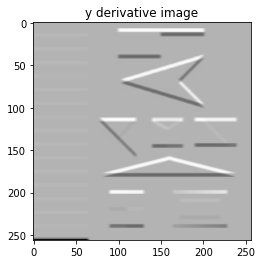

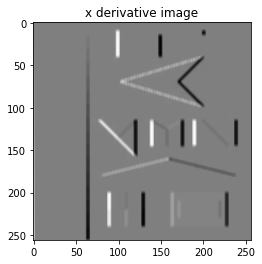

Gx Shape : (256, 256)
Gy Shape : (256, 256)


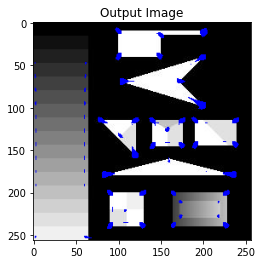

In [7]:
input_img = cv2.imread("images/img1.png")
gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
corner_list, output_img = findImageCorners(gray_img, kernel, method="h", verbose=True)

In [8]:
def saveCornerResult(filename, corner_list, corner_img):
    with open(os.path.join("output", "charts", f"{filename}.csv"), 'w') as corner_file:
        writer = csv.DictWriter(corner_file, fieldnames=["x", "y", "r"])
        writer.writeheader()
        for i in range(len(corner_list)):
            writer.writerow({
                "x": str(corner_list[i][0]),
                "y": str(corner_list[i][1]),
                "r": str(corner_list[i][2])
            })

    if corner_img is not None:
        cv2.imwrite(os.path.join("output", "images", filename), corner_img)

In [9]:
def main():
    files = glob.glob(os.path.join("images", "img*"))
    for file in files:
        filename = file.split(os.path.sep)[-1]
        try:
            input_img = cv2.imread(file)
            gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        except Exception as error:
            print(f"Input {filename}: {error}")
            continue
        corner_list, output_img = findImageCorners(gray_img, kernel, method="n", verbose=True)
        saveCornerResult(filename, corner_list, output_img)